<a href="https://colab.research.google.com/github/SirDripset/Clustering_Practice/blob/main/practice_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import plotly.express as px


In [ ]:
import sklearn
print(sklearn.__version__)

1.1.1


In [ ]:
df1 = pd.read_csv('DNP_ancient_authors.csv', index_col = 'authors').drop(columns=['Unnamed: 0'])

In [ ]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, Achilles Tatius of Alexandria to Zosimus
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   word_count           238 non-null    int64
 1   modern_translations  238 non-null    int64
 2   known_works          238 non-null    int64
 3   manuscripts          238 non-null    int64
 4   early_editions       238 non-null    int64
 5   early_translations   238 non-null    int64
 6   modern_editions      238 non-null    int64
 7   commentaries         238 non-null    int64
dtypes: int64(8)
memory usage: 16.7+ KB
None


In [ ]:
print(df1.head(5))

                                             word_count  modern_translations  \
authors                                                                        
Achilles Tatius of Alexandria                       383                    5   
Aelianus Tacticus                                   350                    1   
Aelianus, Claudius (Aelian)                         746                    8   
Aelius Aristides (Publius Aelius Aristides)        2180                   26   
Aeneas Tacticus                                     304                    5   

                                             known_works  manuscripts  \
authors                                                                 
Achilles Tatius of Alexandria                          1            2   
Aelianus Tacticus                                      1            0   
Aelianus, Claudius (Aelian)                            3            6   
Aelius Aristides (Publius Aelius Aristides)           22            7   
A

In [ ]:
print(df1.describe())

        word_count  modern_translations  known_works  manuscripts  \
count   238.000000           238.000000   238.000000   238.000000   
mean    904.441176            12.970588     4.735294     4.512605   
std     804.388666            16.553047     6.784297     4.637702   
min      99.000000             0.000000     0.000000     0.000000   
25%     448.750000             4.250000     1.000000     1.000000   
50%     704.000000             9.000000     2.000000     3.000000   
75%    1151.500000            15.750000     6.000000     6.000000   
max    9406.000000           178.000000    65.000000    34.000000   

       early_editions  early_translations  modern_editions  commentaries  
count      238.000000          238.000000       238.000000    238.000000  
mean         5.823529            4.794118        10.399160      3.815126  
std          4.250881            6.681706        11.652326      7.013509  
min          0.000000            0.000000         0.000000      0.000000  
25%

In [ ]:
ninety_quantile = df1['word_count'].quantile(0.9)
df1 = df1[df1['word_count'] <= ninety_quantile]

In [ ]:
from sklearn.preprocessing import StandardScaler as SS #Z-Score Standardization
from sklearn.cluster import KMeans, DBSCAN #clustering algorithms
from sklearn.decomposition import PCA #dimensionality reduction
from sklearn.metrics import silhouette_score #evaluate cohesion in cluster
from sklearn.neighbors import NearestNeighbors #selecting optimal eps value when using DBSCAN

In [ ]:
#pip install yellowbrick

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
#below function will be used to plot a silhouette plot to evaluate the cohesion in clusters for K-Means

In [ ]:
def silhouettePlot(range_, data):
    half_length = int(len(range_)/2)
    range_list = list(range_)
    fig, ax = plt.subplots(half_length, 2, figsize=(15,8))
    for _ in range_:
        kmeans = KMeans(n_clusters=_, random_state=42)
        q, mod = divmod(_ - range_list[0], 2)
        sv = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q][mod])
        ax[q][mod].set_title('Silhouette Plot with n={} Cluster'.format(_))
        sv.fit(data)
    fig.tight_layout()
    fig.show()
    fig.savefig("practice_silhouette_plot.png")

In [ ]:
#below function is an elbow plot which helps figure out right amount of clusters for a dataset

In [ ]:
def elbowPlot(range_, data, figsize=(10,10)):
    inertia_list = []
    for n in range_:
        kmeans= KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y= inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()
    fig.savefig("practice_elbow_plot.png")

In [ ]:
#finding optimal eps distance when using DBSCAN

In [ ]:
def findOptimalEps(n_neighbors, data):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sor(distances, axis = 0)
    distances = distances[:,1]
    plt.plot(distances)

In [ ]:
#algorithm to select features from our dataset based on silhouette score and k-means clustering

In [ ]:
def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):
    feature_list = list(df.columns)
    selected_features = list()
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features

In [ ]:
scaler = SS()
DNP_authors_standardized = scaler.fit_transform(df1)
df1_standardized = pd.DataFrame(DNP_authors_standardized, columns=["word_count_standardized", "modern_translations_standardized", "known_works_standardized", "manuscripts_standardized", "early_editions_standardized", "early_translations_standardized", "modern_editions_standardized", "commentaries_standardized"])
df1_standardized = df1_standardized.set_index(df1.index)

In [ ]:
selected_features = progressiveFeatureSelection(df1_standardized, max_features=3, n_clusters=3)

Proposed new feature word_count_standardized with score 0.5815823896749474
Proposed new feature modern_translations_standardized with score 0.592449382653205
Proposed new feature known_works_standardized with score 0.7606223362466435
Proposed new feature manuscripts_standardized with score 0.6193716240205519
Proposed new feature early_editions_standardized with score 0.6054575587243932
Proposed new feature early_translations_standardized with score 0.7025924996773049
Proposed new feature modern_editions_standardized with score 0.6267499859538754
Proposed new feature commentaries_standardized with score 0.7635590362947628
The initial feature is commentaries_standardized with a silhouette score of 0.7635590362947628.
Starting selection 0...
Proposed new feature word_count_standardized with score 0.49823573315720454
Proposed new feature modern_translations_standardized with score 0.48709861763555096
Proposed new feature known_works_standardized with score 0.6248907484676766
Proposed new f

In [ ]:
df_standardized_sliced = df1_standardized[selected_features]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


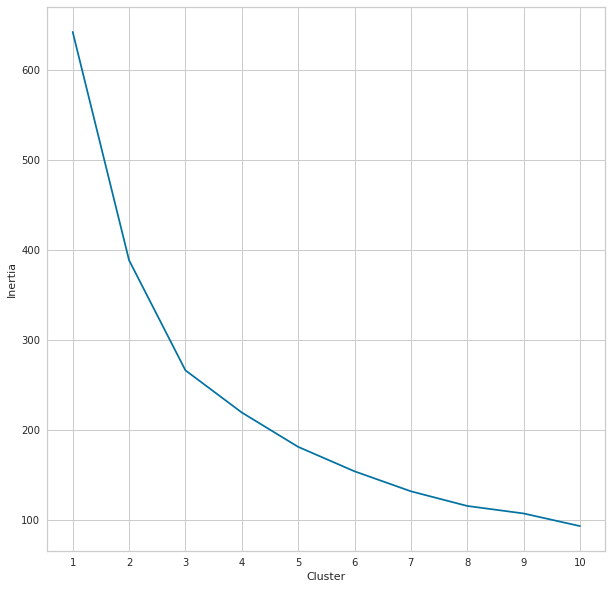

In [ ]:
elbowPlot(range(1,11), df_standardized_sliced)

In [ ]:
#elbow is at n=3 and n=5

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


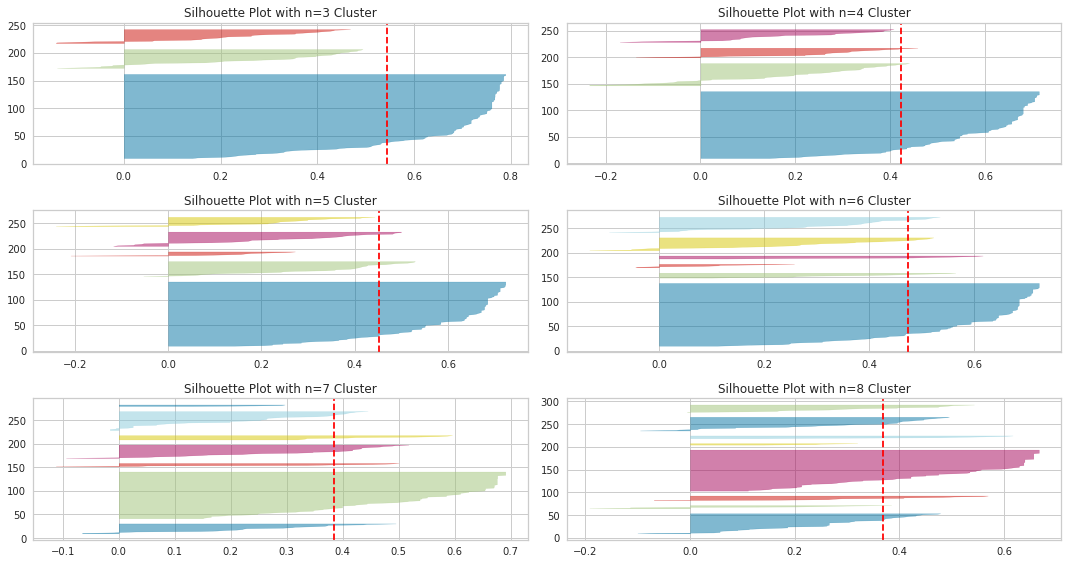

In [ ]:
silhouettePlot(range(3,9), df_standardized_sliced)

/scratch/kdwq643/ipykernel_180484/2525093179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized_sliced['clusters'] = cluster_labels


<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

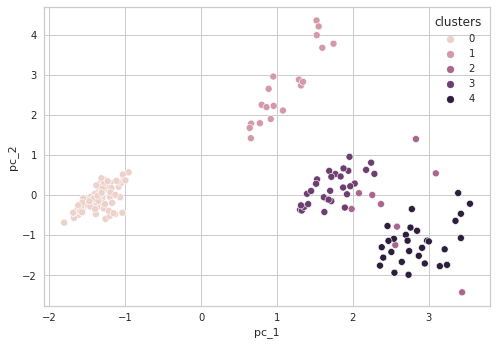

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized_sliced)
df_standardized_sliced['clusters'] = cluster_labels

#using PCA to reduce the dimensionality

pca = PCA(n_components=2, whiten=False, random_state = 42)
authors_standardized_pca = pca.fit_transform(df_standardized_sliced)
df1_standardized_pca = pd.DataFrame(data=authors_standardized_pca, columns = ["pc_1", "pc_2"])
df1_standardized_pca["clusters"] = cluster_labels

#plotting clusters via sns

sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df1_standardized_pca)